### 보스턴 집값 예측
- 데이터셋: boston.csv
- 학습: 지도학습 >> 회귀
- 알고리즘: 선형회귀
- 구현_프레임워크: Pytorch
- Train, test, Validation Dataset 생성

In [16]:
import torch						# 텐서 및 수치 계산 함수 관련 모듈
import torch.nn as nn					# 인공신경망 관련 모듈
import torch.nn.functional as F		# 손실, 거래 등 함수 관련 모듈
import torch.optim as optimizer		# 최적화 기법 관련 모듈

import pandas as pd				# 데이터 파일 분석 관련 모듈

from sklearn.model_selection import train_test_split		# trainDS, testDS 분할 관련 모듈듈
import matplotlib.pyplot as plt

In [17]:
# 랜덤성 고정
torch.manual_seed(1)

####[1] 데이터 준비

In [18]:
DATA_FILE = r"C:\Users\KDP-43\Desktop\머신러닝_1\data\boston.csv"

bostonDF = pd.read_csv(DATA_FILE)			# 컬럼 2개만 사용
bostonDF.head(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.9,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.9,9.14,21.6


<Axes: >

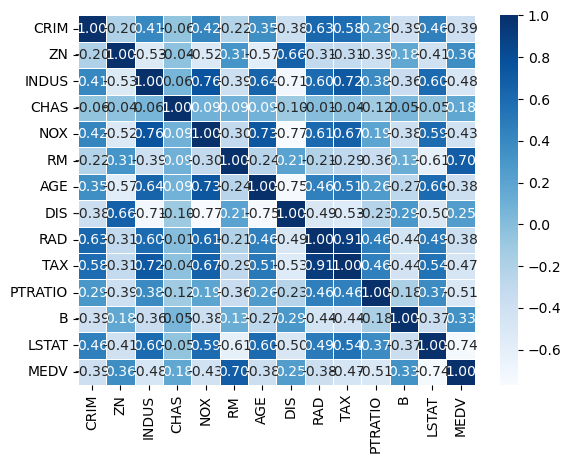

In [19]:
import seaborn as sns
sns.heatmap( bostonDF.corr(numeric_only=True), annot=True, cmap='Blues',
            fmt='.2f',
            linewidths=0.5, cbar=True)

In [20]:
medv_corr = bostonDF.corr(numeric_only=True)['MEDV']

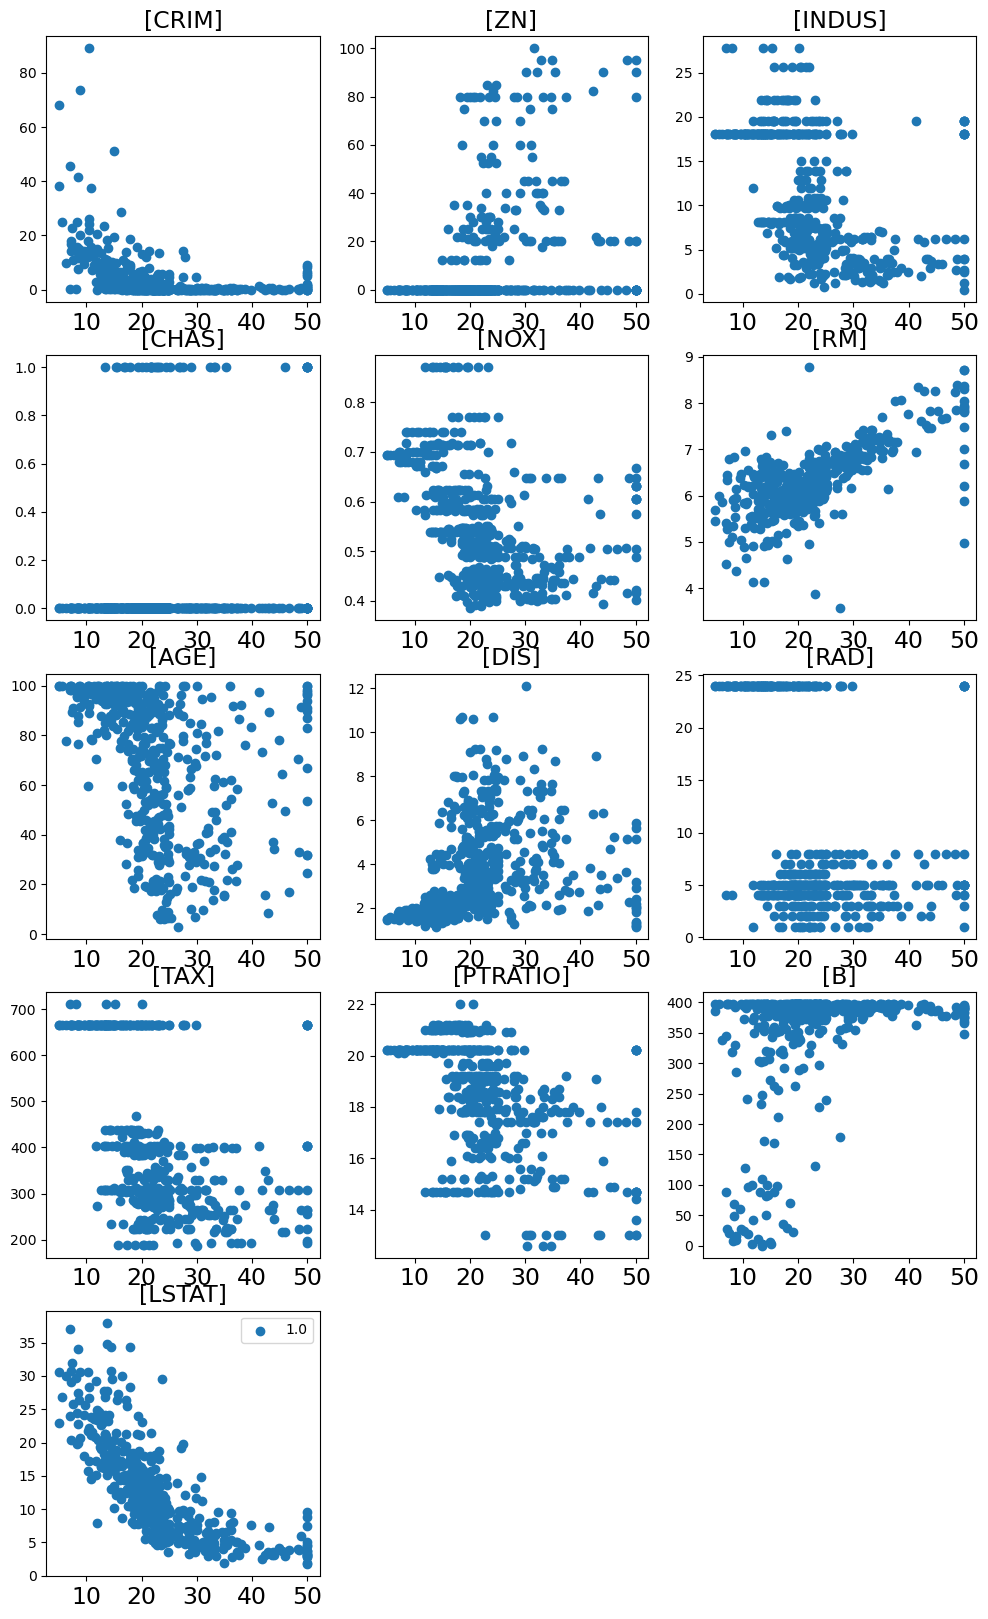

In [21]:
# 타겟 & 피쳐 scatter

col = 3
row = (len(bostonDF.columns[:-1]) + col -1) // col

plt.figure(figsize=(12, row*4))


for i,column in enumerate(bostonDF.columns[:-1], 1):
    plt.subplot(row,col, i)
    
    plt.title(f'[{column}]', fontsize=17)
    plt.scatter(bostonDF['MEDV'], bostonDF[column],
                label=f'{medv_corr[i]}')
    plt.xticks(fontsize=17)
    
plt.legend()
plt.show()

#### [2] 모델 준비
- 학습방법: 지도학습 >> 회귀
- 알고리즘: 선형관계 >> 선형모델 >> nn.Linear
- in_features = RM 1개
- out_features = MEDV 1개

In [22]:
# 타겟 1개, 피쳐 1개
# RM	, MEDV
model = nn.Linear(1,1)

# model_parameter(): Weight, bias
for name, param in model.named_parameters():
  print(f'[{name}] {param}', end='\n\n')

[weight] Parameter containing:
tensor([[0.5153]], requires_grad=True)

[bias] Parameter containing:
tensor([-0.4414], requires_grad=True)



#### [3] Optimizer 준비
- 모델 가중치(Weight), 절편(bias) 최적화


In [23]:
# Adam Optimizer

# 질문) lr => 0.1, 0.01, 0.001 한 번에 넣어서 가능??
adam_optim = optimizer.Adam(model.parameters(),
                            lr=0.1)

#### [4] 모델 학습

##### [4_1] 데이터셋 Tensor & 분리

In [24]:
bostonDF.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

In [25]:
featureTS = torch.from_numpy( bostonDF[['RM']].values ).float()
featureTS.shape

torch.Size([506, 1])

In [26]:
targetTS = torch.from_numpy( bostonDF[ ['MEDV'] ].values).float()
targetTS.shape

torch.Size([506, 1])

##### [4_2] train, test, valid 데이터셋 분리
- 스케일링...!!

In [27]:
# Train & test 분할
X_train, X_test, y_train, y_test = train_test_split(featureTS, targetTS,
                                                    test_size = 0.2, 
                          random_state=10)

# Train & Valid 분할
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    test_size = 0.2, 
                          random_state=10)

print(f'[Feature] Train {X_train.shape}, TEST {X_test.shape}, Valid {X_val.shape}')
print(f'[Target]  Train {y_train.shape}, TEST {y_test.shape}, Valid {y_val.shape}')

[Feature] Train torch.Size([323, 1]), TEST torch.Size([102, 1]), Valid torch.Size([81, 1])
[Target]  Train torch.Size([323, 1]), TEST torch.Size([102, 1]), Valid torch.Size([81, 1])


##### [4_3] 테스트/검증 함수

In [28]:
# 모델 Validation 함수
def testing(testTS, targetTS, kind='Validation'):

	# 가중치 업데이트 없이 학습
	with torch.no_grad():

		# 학습진행
		pre_y = model(testTS)

		# 손실함수 계산
		loss = F.mse_loss(pre_y, targetTS)

		# 학습결과 & 저장
		# print(f'[{kind}] LOSS: {loss}')

	return loss

In [29]:

# 모델 train 함수
def training(featureTS, targetTS, valTS, valTargetTS, 
						 testTS, testTargetTS, EPOCH):
  
	loss_history = { 'Train':[], 'Valid':[], 'Test':[] }

	for epoch in range(EPOCH):
		
		# 학습진행----------------------------
		# pre_y = model(featureTS)
		pre_y = model(featureTS)
		
		# 손실함수 계산--------------------
		loss = F.mse_loss(pre_y, targetTS)
		loss_history['Train'].append(loss.item())
		
		# 최적화 ----------------------------
		# 가중치, 절편 업데이트: backward, step
		
		# gradient 0 초기화
		adam_optim.zero_grad()		

		# 비용함수 미분 => gradient 계산		
		loss.backward()
		
		# W와 b 업데이트
		adam_optim.step()

		# Validation
		# 모델 검증 ---------------------------
		val_loss = testing(valTS, valTargetTS) 
		loss_history['Valid'].append(val_loss.item())

		# Test
		test_loss = testing(testTS, testTargetTS)
		loss_history['Test'].append(test_loss.item())
		
		# 학습결과 출력&저장 --------------------
		# print(f'[{epoch+1}/{EPOCH}] LOSS: {loss}\n')
	return loss_history

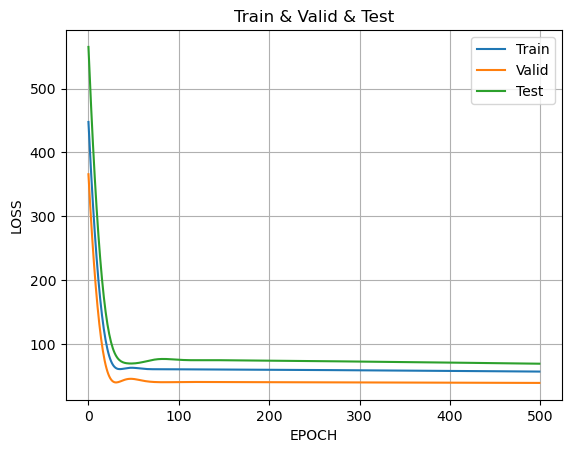

In [30]:
# 학습
EPOCH = 500

loss_per_epoch = training(X_train, y_train, X_val, y_val, 
                          X_test, y_test, EPOCH)


# loss per epoch 시각화
plt.plot(range(len(loss_per_epoch['Train'])), loss_per_epoch['Train'],
         label='Train')
plt.plot(range(len(loss_per_epoch['Valid'])), loss_per_epoch['Valid'],
         label='Valid')
plt.plot(range(len(loss_per_epoch['Test'])), loss_per_epoch['Test'],
         label='Test')

plt.title('Train & Valid & Test')
plt.grid()
plt.xlabel('EPOCH')
plt.ylabel('LOSS')
plt.legend()
plt.show()